<b> Predict Sales  
    Data Description: </b>
You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge. Then:

1. for the list of shops and products I should then create a data frame that can be extended with the new lists.
2. target feature —> total amount of a given product sold in a given shop per month
3. item_cnt_day (# of product sold in a given day)
Then I should create a column item_cnt_month

<b> Features: </b>  
ID - an Id that represents a (Shop, Item) tuple within the test set
* shop_id - unique identifier of a shop
* item_id - unique identifier of a product
* item_category_id - unique identifier of item category
* item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
* item_price - current price of an item
* date - date in format dd/mm/yyyy
* date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,…, October 2015 is 33
* item_name - name of item
* shop_name - name of shop
* item_category_name - name of item category  

In [37]:
import pandas as pd
import numpy as np

<h1> 1. Data Exploring </h1>

<h2> Item Categories </h2>

In [3]:
item_categories = pd.read_csv('Data/item_categories.csv')
#item_categories.head()
item_categories['item_category_name'].value_counts()

Подарки - Атрибутика                        1
Кино - Blu-Ray                              1
Игровые консоли - PS2                       1
Музыка - CD фирменного производства         1
Подарки - Сумки, Альбомы, Коврики д/мыши    1
                                           ..
Доставка товара                             1
Книги - Путеводители                        1
Карты оплаты - PSN                          1
Книги - Артбуки, энциклопедии               1
Служебные                                   1
Name: item_category_name, Length: 84, dtype: int64

* There are 84 item categories.

<h2> Item List </h2>

In [4]:
item_list = pd.read_csv('Data/items.csv')
item_list.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [5]:
item_list['item_id'].shape 

(22170,)

array([[<AxesSubplot:title={'center':'item_id'}>,
        <AxesSubplot:title={'center':'item_category_id'}>]], dtype=object)

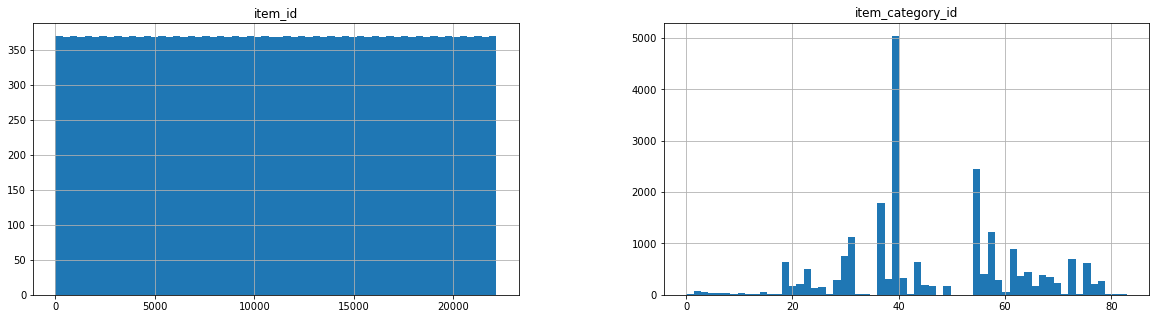

In [6]:
item_list.hist(figsize=(20,5), bins=60)

item_list['item_category_id'].value_counts()

* There are 22170 different items in the store and the features of them --> item_id, item_category_id
* Most of the items belong to item_category #40 which is "Кино - DVD"

In [7]:
#item_list['item_category_id'].isna().sum()
item_list.dtypes

item_name           object
item_id              int64
item_category_id     int64
dtype: object

<h2> Shops </h2>

In [8]:
shops = pd.read_csv('Data/shops.csv')
shops.shape

(60, 2)

* There are 60 shops and their IDs are listed.

<h2> Sample Submission </h2>

A sample submission file in the correct format.

In [9]:
pd.read_csv('Data/sample_submission.csv')

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5
...,...,...
214195,214195,0.5
214196,214196,0.5
214197,214197,0.5
214198,214198,0.5


<h2> sales_train.csv </h2>

The training set. Daily historical data from January 2013 to October 2015.

In [10]:
sales_train = pd.read_csv('Data/sales_train.csv')
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [11]:
sales_train.dtypes

date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object

We should convert the types from object to date_time.

array([[<AxesSubplot:title={'center':'date_block_num'}>,
        <AxesSubplot:title={'center':'shop_id'}>],
       [<AxesSubplot:title={'center':'item_id'}>,
        <AxesSubplot:title={'center':'item_price'}>],
       [<AxesSubplot:title={'center':'item_cnt_day'}>, <AxesSubplot:>]],
      dtype=object)

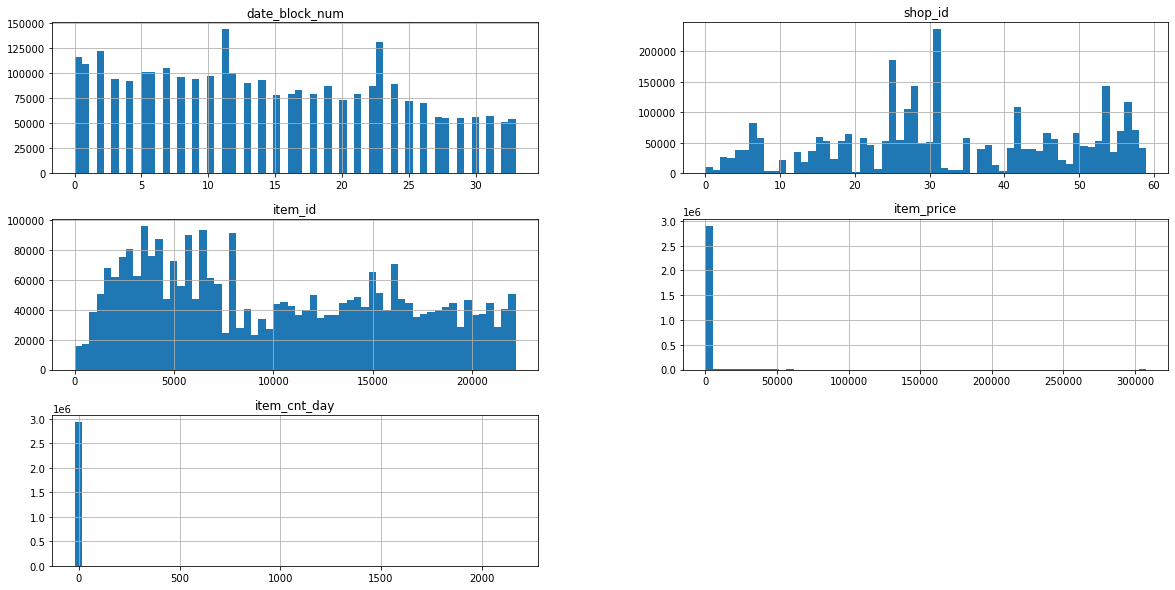

In [12]:
sales_train.hist(figsize=(20,10), bins=60)

<AxesSubplot:xlabel='index', ylabel='item_price'>

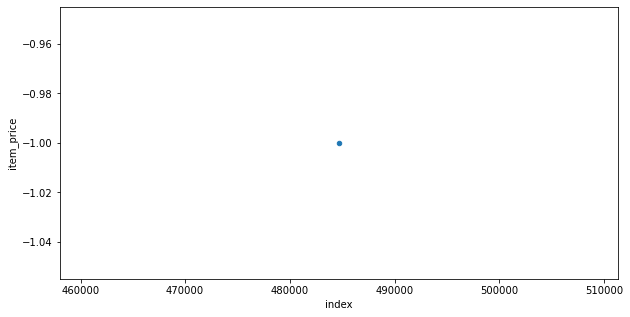

In [13]:
sales_train[sales_train['item_price']<0].reset_index().plot(kind='scatter', y='item_price', x='index', figsize=(10,5))

* There is an item with negative price. We should remove it.

<AxesSubplot:xlabel='index', ylabel='item_price'>

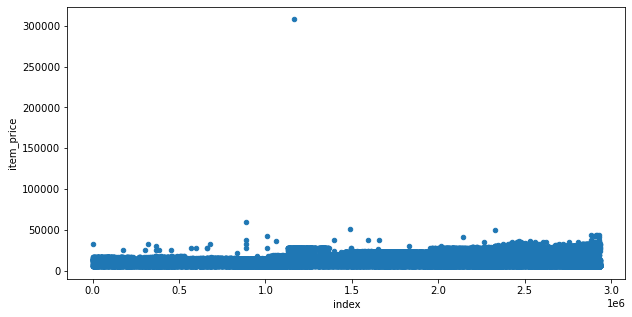

In [14]:
sales_train[(sales_train['item_price']>5000)].reset_index().plot(kind='scatter', y='item_price', x='index', figsize=(10,5))

In [36]:
sales_train[sales_train['item_cnt_day']<0].value_counts()

date        date_block_num  shop_id  item_id  item_price  item_cnt_day
01.01.2013  0               18       6724     299.5       -1.0            1
20.10.2013  9               43       7802     299.0       -1.0            1
                                     3336     2499.0      -1.0            1
                                     3331     1199.0      -1.0            1
                            31       9186     299.0       -1.0            1
                                                                         ..
10.04.2013  3               32       3476     1199.0      -1.0            1
                            26       485      300.0       -1.0            1
                            22       7815     4152.0      -1.0            1
                                     5380     2966.0      -1.0            1
31.12.2014  23              54       1865     2999.0      -1.0            1
Length: 7356, dtype: int64

* There are negative item_cnt_day (# of product counts cannot be negative. However, could -1 mean product return? )

* What is the currency? Do these number make sense? Which products cost the mosts?

In [15]:
sales_train_sorted_on_price = sales_train.sort_values('item_price', ascending=False)

In [16]:
sales_train_sorted_on_price.head()
#item_id= 6066 in shop_id=12 costs the most. it is 

print(item_list[item_list['item_id']==6066])
print(shops[shops['shop_id']==12])
print(sales_train[sales_train['item_id']==6066]) 

                 item_name  item_id  item_category_id
6066  Radmin 3  - 522 лиц.     6066                75
              shop_name  shop_id
12  Интернет-магазин ЧС       12
               date  date_block_num  shop_id  item_id  item_price  \
1163158  13.12.2013              11       12     6066    307980.0   

         item_cnt_day  
1163158           1.0  


I googled it and saw that Radmin 3  - 522 лиц is a remote control software.20 dollars  
Only one shop sells this product. 
307980 russian ruble is 4381.04 USD in October 2021. Thus, the price listed for this product may be unreal. Considering that we do not have any other sample for this product, we may thinking about removing this item from the list. However, I will keep for now.

In [17]:
sales_train['item_id'].value_counts()

20949    31340
5822      9408
17717     9067
2808      7479
4181      6853
         ...  
361          1
3589         1
18784        1
360          1
0            1
Name: item_id, Length: 21807, dtype: int64

There were 22k item types sold. However, there are 21k of them in the training set.

In [18]:
sales_train['shop_id'].value_counts().shape

(60,)

All item categories are represented in the training set.

<AxesSubplot:xlabel='index', ylabel='item_cnt_day'>

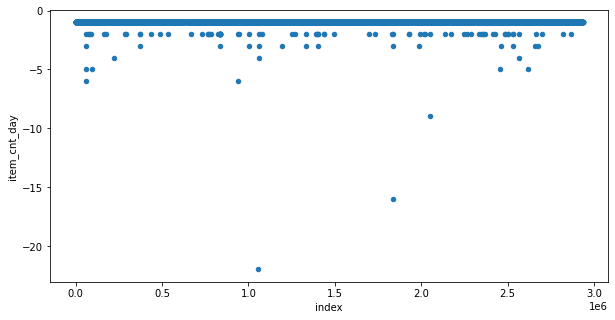

In [19]:
sales_train[sales_train['item_cnt_day']<0].reset_index().plot(kind='scatter', y='item_cnt_day', x='index', figsize=(10,5))

<h2> test.csv </h2>

The test set. You need to forecast the sales for these shops and products for November 2015.

In [20]:
test_set = pd.read_csv('Data/test.csv')
test_set.head()
test_set.shape

(214200, 3)

In [21]:
test_set.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [22]:
test_set.isna().sum()

ID         0
shop_id    0
item_id    0
dtype: int64

In [23]:
test_set.dtypes

ID         int64
shop_id    int64
item_id    int64
dtype: object

In [24]:
len(test_set['shop_id'].value_counts())

42

Only 42/60 shops are represented in the test set.

In [25]:
test_set['item_id'].value_counts()

2049     42
6743     42
13266    42
21342    42
17244    42
         ..
7338     42
1193     42
3240     42
13359    42
2047     42
Name: item_id, Length: 5100, dtype: int64

Each item type appears 42 times in the test_data. 5100/22170 item types are represented in the test set.

<h1> 2. Data Preparation </h1>

In [26]:
sales_train_prepared = sales_train.copy()

In [27]:
sales_train_prepared['date'] = pd.to_datetime(sales_train_prepared['date'])
sales_train_prepared['salesYear'] = sales_train_prepared['date'].dt.year
sales_train_prepared['salesMonth'] = sales_train_prepared['date'].dt.month
sales_train_prepared['salesDay'] = sales_train_prepared['date'].dt.day
sales_train_prepared['salesDate'] = sales_train_prepared['date'].dt.date

In [30]:
sales_train_prepared.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,salesYear,salesMonth,salesDay,salesDate
0,2013-02-01,0,59,22154,999.00,1.0,2013,2,1,2013-02-01
1,2013-03-01,0,25,2552,899.00,1.0,2013,3,1,2013-03-01
2,2013-05-01,0,25,2552,899.00,-1.0,2013,5,1,2013-05-01
3,2013-06-01,0,25,2554,1709.05,1.0,2013,6,1,2013-06-01
4,2013-01-15,0,25,2555,1099.00,1.0,2013,1,15,2013-01-15


In [31]:
#sales_train[sales_train['item_cnt_day']>100].hist(figsize=(10,5), bins=60)
#item_cnt_day - number of products sold. You are predicting a monthly amount of this measure

In [33]:
sales_train_prepared['item_cnt_day'] = sales_train_prepared['item_cnt_day'].astype(int)

array([[<AxesSubplot:title={'center':'date'}>,
        <AxesSubplot:title={'center':'date_block_num'}>,
        <AxesSubplot:title={'center':'shop_id'}>],
       [<AxesSubplot:title={'center':'item_id'}>,
        <AxesSubplot:title={'center':'item_price'}>,
        <AxesSubplot:title={'center':'item_cnt_day'}>],
       [<AxesSubplot:title={'center':'salesYear'}>,
        <AxesSubplot:title={'center':'salesMonth'}>,
        <AxesSubplot:title={'center':'salesDay'}>]], dtype=object)

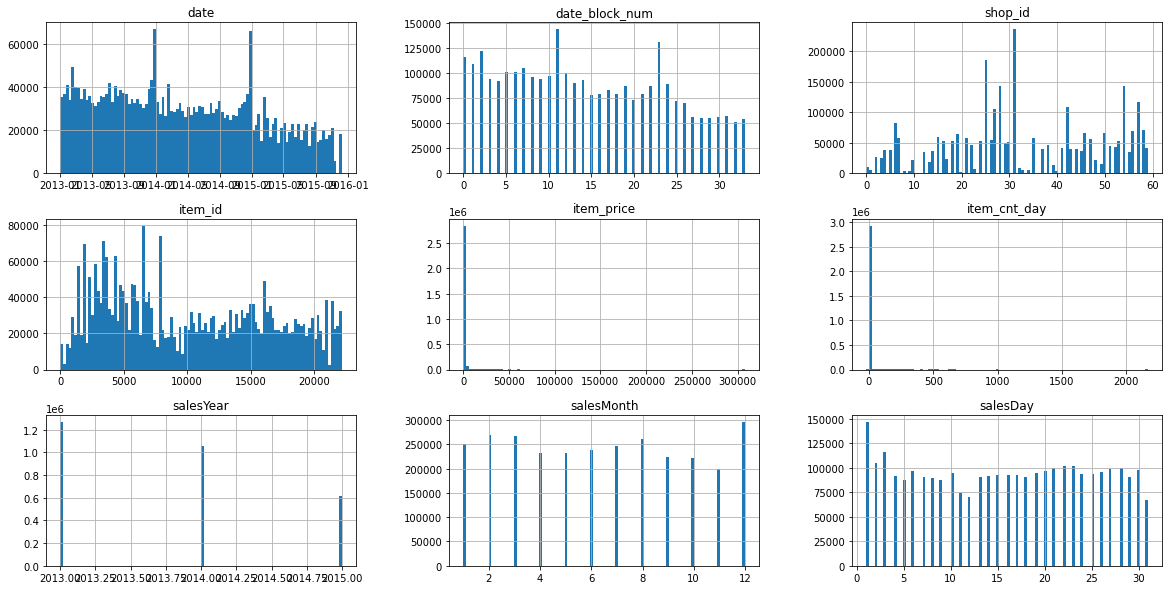

In [35]:
sales_train_prepared.hist(figsize=(20, 10), bins=100)